# Custom object detector

Reference: 06 transfer learning

### Import libraries

In [1]:
import torch
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2
from typing import List, Tuple
from PIL import Image
import imutils
from pathlib import Path
import pprint

from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter

# Custom imports
import model
import engine
from utils import (
    set_seed, 
    plot_loss_curves, 
    create_confusion_matrix, 
    save_model as model_save, 
    pred_and_plot_img, 
    crawl_through_dir, 
    visualize_dataset,
    save_plot)
import config
import dataset


/home/kpatel2s/miniconda3/envs/pytorch_practice/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load hyperparameters

In [3]:
NUM_WORKERS = config.NUM_WORKERS
BATCH_SIZE = config.BATCH_SIZE
PIN_MEMORY = config.PIN_MEMORY

num_classes = config.NUM_CLASSES

IMAGE_SIZE = config.IMAGE_SIZE

EPOCHS = config.EPOCHS
LR_RATE = config.LR_RATE

In [4]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


### Load the dataset

In [5]:
# Setup path to data folder
data_path = Path(config.DATASET)

# image files paths and annotations
images_path = os.path.join(data_path, "images")
annotations_path = os.path.join(data_path, "yolo", "annotations")

images_path, annotations_path

('/home/kpatel2s/kpatel2s/object_detection/custom_object_detector/dataset/standford_dogs_mini_10/images',
 '/home/kpatel2s/kpatel2s/object_detection/custom_object_detector/dataset/standford_dogs_mini_10/yolo/annotations')

### Create data loaders

In [6]:
train_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="train",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

valid_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="valid",
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

test_dataloader = dataset.create_dataloader(
    images_path=images_path,
    annotations_path=annotations_path,
    subset="test",
    batch_size=1,
    pin_memory=PIN_MEMORY,
    transforms=None,
    num_workers=NUM_WORKERS
)

print(f"Class names:")
pprint.pprint(config.CLASS_NAMES)

Class names:
['Chihuahua',
 'Golden_retriever',
 'Welsh_springer_spaniel',
 'German_shepherd',
 'Doberman',
 'Boxer',
 'Siberian_husky',
 'Pug',
 'Pomeranian',
 'Cardigan']


### Visualize samples from the dataset

<Figure size 2000x2000 with 0 Axes>

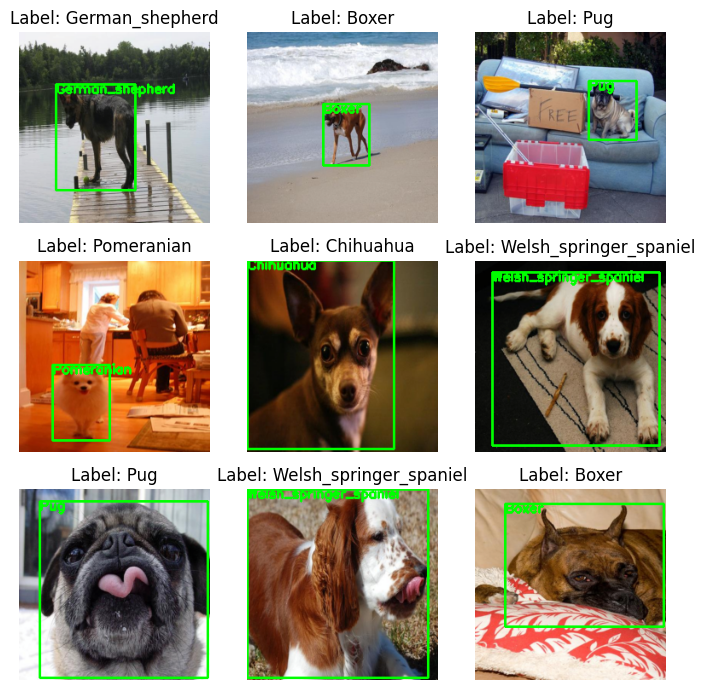

In [7]:
visualize_dataset(train_dataloader, save_fig=True)

### Setup the model

In [8]:
# Create the network
weights = torchvision.models.ResNet50_Weights.DEFAULT
basemodel = torchvision.models.resnet50(weights=weights)

model = model.ObjectDetector(basemodel, num_classes)

#### Get the model summary

In [9]:
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all layers are trainable

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   True
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   True
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]    

#### Freeze ResNet50 weights (backbone)

In [10]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [11]:
x = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))    

summary(model=model, 
        input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

# NOTE: all ResNet50 layers are not trainable (False) and only 
# classification and bbox regression layers are trainable (True)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjectDetector (ObjectDetector)               [1, 3, 224, 224]     [1, 10]              --                   Partial
├─ResNet (backbone)                           [1, 3, 224, 224]     [1, 2048]            --                   False
│    └─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
│    └─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
│    └─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 

### Loss function and optimizer

In [12]:
# Two loss functions
classLoss_function = torch.nn.CrossEntropyLoss()
bboxLoss_function = torch.nn.MSELoss()
loss_fn = (classLoss_function, bboxLoss_function)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LR_RATE)

### Model tracking using Tensorboard

In [13]:
def create_write(experiment_name: str,
                 model_name: str,
                 extra: str=None):
    
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    if extra:
        log_dir = os.path.join(config.PARENT_DIR, "results", config.DATASET_NAME, "runs", config.TIMESTAMP, extra)
    else:
        log_dir = os.path.join(config.PARENT_DIR, "results", config.DATASET_NAME, "runs", config.TIMESTAMP)

    print(f"[INFO] Created SummaryWriter directory: {log_dir}")

    return SummaryWriter(log_dir=log_dir)

### Train the model

In [14]:
set_seed(seed=config.SEED)

from timeit import default_timer as timer
start_time = timer()

model_writer = create_write(experiment_name="standford_dogs_mini_10",
                           model_name=f"model_epoch_{EPOCHS}",)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device,
                       writer=model_writer,
                       save_model=True)

end_time = timer()
print(f"Time elapsed: {end_time - start_time:.3f} seconds")

# Save model
model_save_path = os.path.join(config.PARENT_DIR, "results", config.DATASET_NAME, config.TIMESTAMP, "model")
model_save(model=model, target_dir=model_save_path, model_name=f"last_epoch_{EPOCHS}_{config.MODEL_LOG}.pth")
print(f"[INFO] Last epoch Model saved to: {model_save_path}")

[INFO] Created SummaryWriter directory: /home/kpatel2s/kpatel2s/object_detection/custom_object_detector/results/standford_dogs_mini_10/runs/2023-10-03_21-40


  2%|▏         | 1/50 [00:04<03:42,  4.54s/it]

Epoch: 1 | train_loss: 2.3785 | train_cls_loss: 2.2360 | train_bbox_loss: 0.1425 | train_acc: 0.1560 | valid_loss: 2.2292 | valid_cls_loss: 2.0991 | valid_bbox_loss: 0.1301 | valid_acc: 0.3766


  4%|▍         | 2/50 [00:08<03:26,  4.30s/it]

Epoch: 2 | train_loss: 2.0425 | train_cls_loss: 1.9361 | train_bbox_loss: 0.1064 | train_acc: 0.2958 | valid_loss: 1.6449 | valid_cls_loss: 1.5588 | valid_bbox_loss: 0.0861 | valid_acc: 0.4241


  6%|▌         | 3/50 [00:12<03:20,  4.26s/it]

Epoch: 3 | train_loss: 1.4239 | train_cls_loss: 1.3592 | train_bbox_loss: 0.0647 | train_acc: 0.4160 | valid_loss: 0.8956 | valid_cls_loss: 0.8451 | valid_bbox_loss: 0.0505 | valid_acc: 0.4799


  8%|▊         | 4/50 [00:17<03:15,  4.25s/it]

Epoch: 4 | train_loss: 0.7658 | train_cls_loss: 0.7290 | train_bbox_loss: 0.0368 | train_acc: 0.4689 | valid_loss: 0.4223 | valid_cls_loss: 0.3902 | valid_bbox_loss: 0.0321 | valid_acc: 0.5189


 10%|█         | 5/50 [00:21<03:12,  4.27s/it]

Epoch: 5 | train_loss: 0.4510 | train_cls_loss: 0.4233 | train_bbox_loss: 0.0277 | train_acc: 0.5159 | valid_loss: 0.2435 | valid_cls_loss: 0.2167 | valid_bbox_loss: 0.0268 | valid_acc: 0.5485


 12%|█▏        | 6/50 [00:25<03:08,  4.28s/it]

Epoch: 6 | train_loss: 0.3052 | train_cls_loss: 0.2796 | train_bbox_loss: 0.0256 | train_acc: 0.5439 | valid_loss: 0.1648 | valid_cls_loss: 0.1399 | valid_bbox_loss: 0.0249 | valid_acc: 0.5600


 14%|█▍        | 7/50 [00:29<03:02,  4.25s/it]

Epoch: 7 | train_loss: 0.2245 | train_cls_loss: 0.2005 | train_bbox_loss: 0.0239 | train_acc: 0.5543 | valid_loss: 0.1213 | valid_cls_loss: 0.0986 | valid_bbox_loss: 0.0227 | valid_acc: 0.5695


 16%|█▌        | 8/50 [00:34<02:59,  4.26s/it]

Epoch: 8 | train_loss: 0.1824 | train_cls_loss: 0.1600 | train_bbox_loss: 0.0224 | train_acc: 0.5645 | valid_loss: 0.1017 | valid_cls_loss: 0.0808 | valid_bbox_loss: 0.0209 | valid_acc: 0.5705


 18%|█▊        | 9/50 [00:38<02:54,  4.26s/it]

Epoch: 9 | train_loss: 0.1623 | train_cls_loss: 0.1417 | train_bbox_loss: 0.0207 | train_acc: 0.5746 | valid_loss: 0.0865 | valid_cls_loss: 0.0669 | valid_bbox_loss: 0.0195 | valid_acc: 0.5763


 20%|██        | 10/50 [00:42<02:50,  4.26s/it]

Epoch: 10 | train_loss: 0.1341 | train_cls_loss: 0.1149 | train_bbox_loss: 0.0192 | train_acc: 0.5760 | valid_loss: 0.0769 | valid_cls_loss: 0.0590 | valid_bbox_loss: 0.0179 | valid_acc: 0.5815


 22%|██▏       | 11/50 [00:47<02:47,  4.29s/it]

Epoch: 11 | train_loss: 0.1155 | train_cls_loss: 0.0977 | train_bbox_loss: 0.0178 | train_acc: 0.5838 | valid_loss: 0.0704 | valid_cls_loss: 0.0537 | valid_bbox_loss: 0.0167 | valid_acc: 0.5865


 24%|██▍       | 12/50 [00:51<02:42,  4.27s/it]

Epoch: 12 | train_loss: 0.0972 | train_cls_loss: 0.0806 | train_bbox_loss: 0.0166 | train_acc: 0.5868 | valid_loss: 0.0652 | valid_cls_loss: 0.0492 | valid_bbox_loss: 0.0160 | valid_acc: 0.5817


 26%|██▌       | 13/50 [00:55<02:38,  4.28s/it]

Epoch: 13 | train_loss: 0.0755 | train_cls_loss: 0.0600 | train_bbox_loss: 0.0154 | train_acc: 0.5900 | valid_loss: 0.0574 | valid_cls_loss: 0.0429 | valid_bbox_loss: 0.0146 | valid_acc: 0.5928


 28%|██▊       | 14/50 [00:59<02:33,  4.27s/it]

Epoch: 14 | train_loss: 0.0781 | train_cls_loss: 0.0635 | train_bbox_loss: 0.0145 | train_acc: 0.5950 | valid_loss: 0.0535 | valid_cls_loss: 0.0398 | valid_bbox_loss: 0.0137 | valid_acc: 0.5926


 30%|███       | 15/50 [01:04<02:30,  4.29s/it]

Epoch: 15 | train_loss: 0.0671 | train_cls_loss: 0.0534 | train_bbox_loss: 0.0137 | train_acc: 0.6011 | valid_loss: 0.0516 | valid_cls_loss: 0.0391 | valid_bbox_loss: 0.0125 | valid_acc: 0.6117


 32%|███▏      | 16/50 [01:08<02:27,  4.34s/it]

Epoch: 16 | train_loss: 0.0685 | train_cls_loss: 0.0555 | train_bbox_loss: 0.0130 | train_acc: 0.6030 | valid_loss: 0.0489 | valid_cls_loss: 0.0370 | valid_bbox_loss: 0.0120 | valid_acc: 0.6152


 34%|███▍      | 17/50 [01:13<02:24,  4.37s/it]

Epoch: 17 | train_loss: 0.0652 | train_cls_loss: 0.0525 | train_bbox_loss: 0.0127 | train_acc: 0.6111 | valid_loss: 0.0472 | valid_cls_loss: 0.0357 | valid_bbox_loss: 0.0115 | valid_acc: 0.6215


 36%|███▌      | 18/50 [01:17<02:19,  4.36s/it]

Epoch: 18 | train_loss: 0.0593 | train_cls_loss: 0.0471 | train_bbox_loss: 0.0121 | train_acc: 0.6102 | valid_loss: 0.0459 | valid_cls_loss: 0.0350 | valid_bbox_loss: 0.0108 | valid_acc: 0.6371


 38%|███▊      | 19/50 [01:21<02:14,  4.32s/it]

Epoch: 19 | train_loss: 0.0395 | train_cls_loss: 0.0277 | train_bbox_loss: 0.0118 | train_acc: 0.6128 | valid_loss: 0.0462 | valid_cls_loss: 0.0357 | valid_bbox_loss: 0.0105 | valid_acc: 0.6314


 40%|████      | 20/50 [01:26<02:10,  4.35s/it]

Epoch: 20 | train_loss: 0.0428 | train_cls_loss: 0.0313 | train_bbox_loss: 0.0114 | train_acc: 0.6200 | valid_loss: 0.0414 | valid_cls_loss: 0.0314 | valid_bbox_loss: 0.0101 | valid_acc: 0.6398


 42%|████▏     | 21/50 [01:30<02:04,  4.30s/it]

Epoch: 21 | train_loss: 0.0434 | train_cls_loss: 0.0321 | train_bbox_loss: 0.0113 | train_acc: 0.6185 | valid_loss: 0.0449 | valid_cls_loss: 0.0347 | valid_bbox_loss: 0.0102 | valid_acc: 0.6299


 44%|████▍     | 22/50 [01:34<02:00,  4.31s/it]

Epoch: 22 | train_loss: 0.0413 | train_cls_loss: 0.0304 | train_bbox_loss: 0.0109 | train_acc: 0.6216 | valid_loss: 0.0459 | valid_cls_loss: 0.0363 | valid_bbox_loss: 0.0096 | valid_acc: 0.6397


 46%|████▌     | 23/50 [01:38<01:57,  4.34s/it]

Epoch: 23 | train_loss: 0.0336 | train_cls_loss: 0.0228 | train_bbox_loss: 0.0108 | train_acc: 0.6293 | valid_loss: 0.0397 | valid_cls_loss: 0.0300 | valid_bbox_loss: 0.0097 | valid_acc: 0.6336


 48%|████▊     | 24/50 [01:43<01:53,  4.35s/it]

Epoch: 24 | train_loss: 0.0341 | train_cls_loss: 0.0235 | train_bbox_loss: 0.0106 | train_acc: 0.6227 | valid_loss: 0.0461 | valid_cls_loss: 0.0370 | valid_bbox_loss: 0.0091 | valid_acc: 0.6469


 50%|█████     | 25/50 [01:47<01:48,  4.35s/it]

Epoch: 25 | train_loss: 0.0357 | train_cls_loss: 0.0251 | train_bbox_loss: 0.0106 | train_acc: 0.6267 | valid_loss: 0.0436 | valid_cls_loss: 0.0346 | valid_bbox_loss: 0.0090 | valid_acc: 0.6538


 52%|█████▏    | 26/50 [01:52<01:44,  4.34s/it]

Epoch: 26 | train_loss: 0.0308 | train_cls_loss: 0.0206 | train_bbox_loss: 0.0102 | train_acc: 0.6233 | valid_loss: 0.0470 | valid_cls_loss: 0.0381 | valid_bbox_loss: 0.0089 | valid_acc: 0.6503


 54%|█████▍    | 27/50 [01:56<01:39,  4.31s/it]

Epoch: 27 | train_loss: 0.0337 | train_cls_loss: 0.0235 | train_bbox_loss: 0.0102 | train_acc: 0.6286 | valid_loss: 0.0372 | valid_cls_loss: 0.0285 | valid_bbox_loss: 0.0087 | valid_acc: 0.6495


 56%|█████▌    | 28/50 [02:00<01:34,  4.30s/it]

Epoch: 28 | train_loss: 0.0266 | train_cls_loss: 0.0168 | train_bbox_loss: 0.0099 | train_acc: 0.6342 | valid_loss: 0.0371 | valid_cls_loss: 0.0284 | valid_bbox_loss: 0.0087 | valid_acc: 0.6478


 58%|█████▊    | 29/50 [02:04<01:30,  4.33s/it]

Epoch: 29 | train_loss: 0.0235 | train_cls_loss: 0.0139 | train_bbox_loss: 0.0096 | train_acc: 0.6342 | valid_loss: 0.0415 | valid_cls_loss: 0.0330 | valid_bbox_loss: 0.0084 | valid_acc: 0.6521


 60%|██████    | 30/50 [02:09<01:26,  4.34s/it]

Epoch: 30 | train_loss: 0.0254 | train_cls_loss: 0.0158 | train_bbox_loss: 0.0096 | train_acc: 0.6331 | valid_loss: 0.0397 | valid_cls_loss: 0.0314 | valid_bbox_loss: 0.0083 | valid_acc: 0.6498


 62%|██████▏   | 31/50 [02:13<01:22,  4.33s/it]

Epoch: 31 | train_loss: 0.0257 | train_cls_loss: 0.0162 | train_bbox_loss: 0.0095 | train_acc: 0.6337 | valid_loss: 0.0448 | valid_cls_loss: 0.0365 | valid_bbox_loss: 0.0083 | valid_acc: 0.6533


 64%|██████▍   | 32/50 [02:18<01:18,  4.36s/it]

Epoch: 32 | train_loss: 0.0200 | train_cls_loss: 0.0106 | train_bbox_loss: 0.0094 | train_acc: 0.6376 | valid_loss: 0.0408 | valid_cls_loss: 0.0328 | valid_bbox_loss: 0.0080 | valid_acc: 0.6575


 66%|██████▌   | 33/50 [02:22<01:14,  4.37s/it]

Epoch: 33 | train_loss: 0.0255 | train_cls_loss: 0.0164 | train_bbox_loss: 0.0091 | train_acc: 0.6392 | valid_loss: 0.0416 | valid_cls_loss: 0.0338 | valid_bbox_loss: 0.0078 | valid_acc: 0.6588


 68%|██████▊   | 34/50 [02:26<01:10,  4.38s/it]

Epoch: 34 | train_loss: 0.0205 | train_cls_loss: 0.0115 | train_bbox_loss: 0.0089 | train_acc: 0.6406 | valid_loss: 0.0412 | valid_cls_loss: 0.0335 | valid_bbox_loss: 0.0077 | valid_acc: 0.6616


 70%|███████   | 35/50 [02:31<01:06,  4.41s/it]

Epoch: 35 | train_loss: 0.0275 | train_cls_loss: 0.0188 | train_bbox_loss: 0.0087 | train_acc: 0.6406 | valid_loss: 0.0344 | valid_cls_loss: 0.0268 | valid_bbox_loss: 0.0076 | valid_acc: 0.6627


 72%|███████▏  | 36/50 [02:35<01:01,  4.39s/it]

Epoch: 36 | train_loss: 0.0197 | train_cls_loss: 0.0112 | train_bbox_loss: 0.0085 | train_acc: 0.6448 | valid_loss: 0.0376 | valid_cls_loss: 0.0301 | valid_bbox_loss: 0.0075 | valid_acc: 0.6559


 74%|███████▍  | 37/50 [02:39<00:56,  4.35s/it]

Epoch: 37 | train_loss: 0.0164 | train_cls_loss: 0.0081 | train_bbox_loss: 0.0083 | train_acc: 0.6462 | valid_loss: 0.0392 | valid_cls_loss: 0.0320 | valid_bbox_loss: 0.0072 | valid_acc: 0.6605


 76%|███████▌  | 38/50 [02:44<00:52,  4.36s/it]

Epoch: 38 | train_loss: 0.0191 | train_cls_loss: 0.0108 | train_bbox_loss: 0.0083 | train_acc: 0.6446 | valid_loss: 0.0361 | valid_cls_loss: 0.0289 | valid_bbox_loss: 0.0072 | valid_acc: 0.6636


 78%|███████▊  | 39/50 [02:48<00:48,  4.38s/it]

Epoch: 39 | train_loss: 0.0247 | train_cls_loss: 0.0166 | train_bbox_loss: 0.0081 | train_acc: 0.6469 | valid_loss: 0.0329 | valid_cls_loss: 0.0259 | valid_bbox_loss: 0.0070 | valid_acc: 0.6640


 80%|████████  | 40/50 [02:53<00:43,  4.37s/it]

Epoch: 40 | train_loss: 0.0164 | train_cls_loss: 0.0086 | train_bbox_loss: 0.0078 | train_acc: 0.6490 | valid_loss: 0.0431 | valid_cls_loss: 0.0363 | valid_bbox_loss: 0.0068 | valid_acc: 0.6686


 82%|████████▏ | 41/50 [02:57<00:39,  4.37s/it]

Epoch: 41 | train_loss: 0.0161 | train_cls_loss: 0.0084 | train_bbox_loss: 0.0077 | train_acc: 0.6526 | valid_loss: 0.0378 | valid_cls_loss: 0.0310 | valid_bbox_loss: 0.0068 | valid_acc: 0.6627


 84%|████████▍ | 42/50 [03:01<00:35,  4.38s/it]

Epoch: 42 | train_loss: 0.0187 | train_cls_loss: 0.0113 | train_bbox_loss: 0.0074 | train_acc: 0.6540 | valid_loss: 0.0409 | valid_cls_loss: 0.0342 | valid_bbox_loss: 0.0066 | valid_acc: 0.6692


 86%|████████▌ | 43/50 [03:06<00:30,  4.38s/it]

Epoch: 43 | train_loss: 0.0164 | train_cls_loss: 0.0091 | train_bbox_loss: 0.0073 | train_acc: 0.6549 | valid_loss: 0.0430 | valid_cls_loss: 0.0365 | valid_bbox_loss: 0.0065 | valid_acc: 0.6705


 88%|████████▊ | 44/50 [03:10<00:26,  4.38s/it]

Epoch: 44 | train_loss: 0.0159 | train_cls_loss: 0.0088 | train_bbox_loss: 0.0071 | train_acc: 0.6576 | valid_loss: 0.0417 | valid_cls_loss: 0.0354 | valid_bbox_loss: 0.0064 | valid_acc: 0.6764


 90%|█████████ | 45/50 [03:14<00:21,  4.36s/it]

Epoch: 45 | train_loss: 0.0150 | train_cls_loss: 0.0081 | train_bbox_loss: 0.0069 | train_acc: 0.6621 | valid_loss: 0.0432 | valid_cls_loss: 0.0369 | valid_bbox_loss: 0.0063 | valid_acc: 0.6741


 92%|█████████▏| 46/50 [03:19<00:17,  4.33s/it]

Epoch: 46 | train_loss: 0.0125 | train_cls_loss: 0.0057 | train_bbox_loss: 0.0068 | train_acc: 0.6632 | valid_loss: 0.0420 | valid_cls_loss: 0.0359 | valid_bbox_loss: 0.0062 | valid_acc: 0.6721


 94%|█████████▍| 47/50 [03:23<00:13,  4.34s/it]

Epoch: 47 | train_loss: 0.0144 | train_cls_loss: 0.0079 | train_bbox_loss: 0.0065 | train_acc: 0.6636 | valid_loss: 0.0352 | valid_cls_loss: 0.0291 | valid_bbox_loss: 0.0061 | valid_acc: 0.6746


 96%|█████████▌| 48/50 [03:27<00:08,  4.37s/it]

Epoch: 48 | train_loss: 0.0137 | train_cls_loss: 0.0072 | train_bbox_loss: 0.0065 | train_acc: 0.6614 | valid_loss: 0.0463 | valid_cls_loss: 0.0404 | valid_bbox_loss: 0.0059 | valid_acc: 0.6788


 98%|█████████▊| 49/50 [03:32<00:04,  4.38s/it]

Epoch: 49 | train_loss: 0.0142 | train_cls_loss: 0.0079 | train_bbox_loss: 0.0062 | train_acc: 0.6658 | valid_loss: 0.0470 | valid_cls_loss: 0.0414 | valid_bbox_loss: 0.0056 | valid_acc: 0.6832


100%|██████████| 50/50 [03:36<00:00,  4.33s/it]

Epoch: 50 | train_loss: 0.0158 | train_cls_loss: 0.0096 | train_bbox_loss: 0.0063 | train_acc: 0.6677 | valid_loss: 0.0376 | valid_cls_loss: 0.0320 | valid_bbox_loss: 0.0056 | valid_acc: 0.6819
Time elapsed: 216.643 seconds
[INFO] Last epoch Model saved to: /home/kpatel2s/kpatel2s/object_detection/custom_object_detector/results/standford_dogs_mini_10/2023-10-03_21-40/model


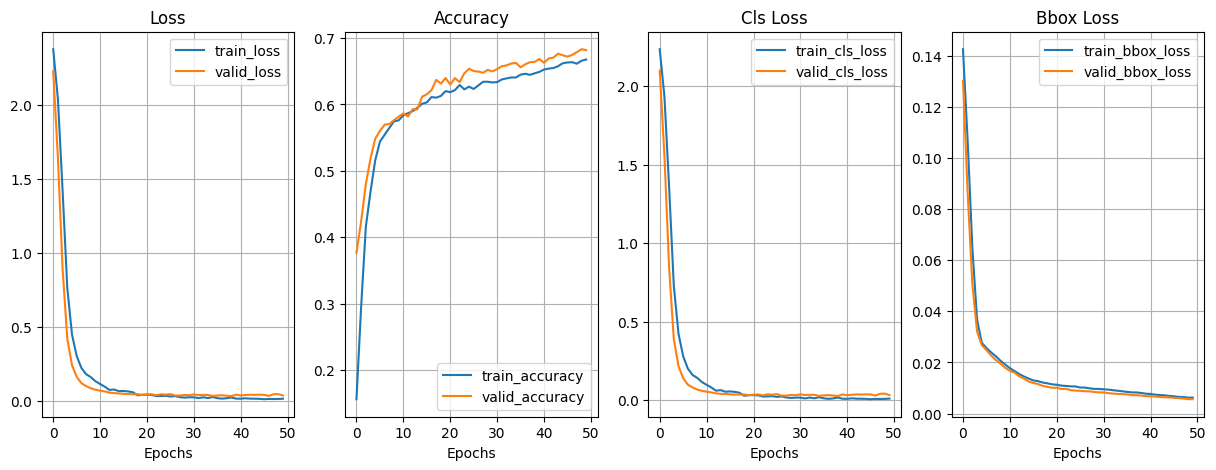

In [15]:
# Evaluation
plot_loss_curves(results=results, save_fig=True)

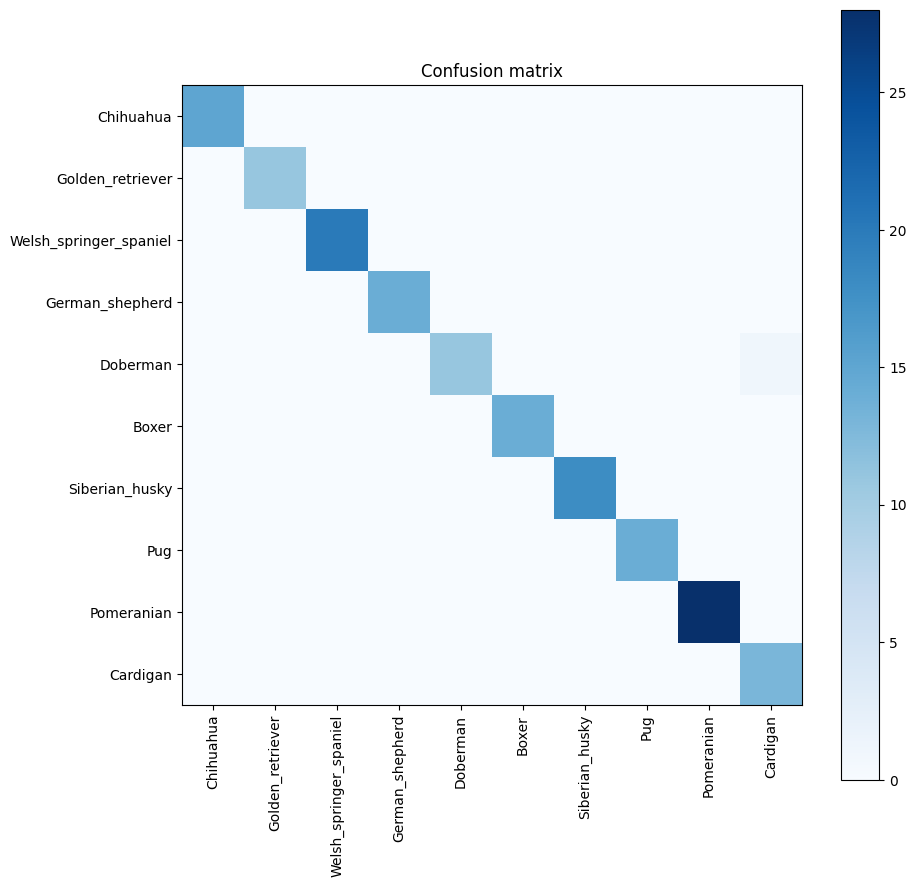

In [16]:
create_confusion_matrix(model=model,
                        test_loader=test_dataloader,
                        class_names=config.CLASS_NAMES,
                        device=device,
                        save_fig=True)

### Inference on images

In [17]:
if config.LOAD_MODEL:
    print("[INFO] Loading model...")
    # load the model weights
    weights_file = config.MODEL_PATH
    model.load_state_dict(torch.load(weights_file))

<Figure size 2000x2000 with 0 Axes>

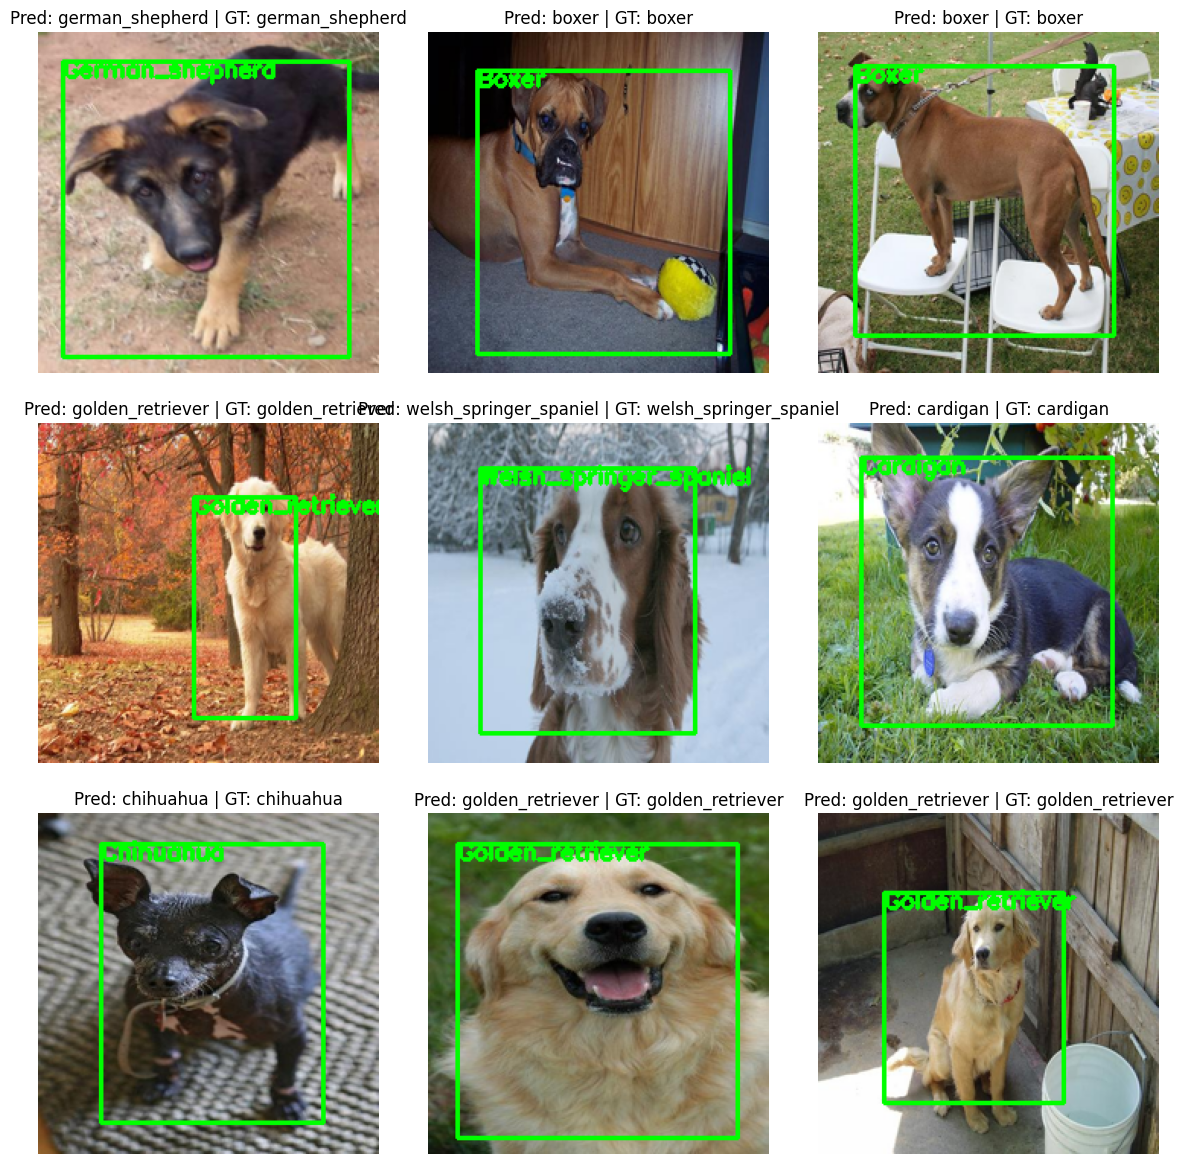

In [18]:
test_dir = "/home/kpatel2s/kpatel2s/object_detection/custom_object_detector/dataset/standford_dogs_mini_10/images"

num_imgs = 9
test_img_path_list = crawl_through_dir(test_dir)
test_img_path_sample = random.sample(test_img_path_list, num_imgs)

# Set figure size
plt.figure(figsize=(20, 20)) 

# Set subplot parameters
plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, test_img in enumerate(test_img_path_sample):
    # plot output images
    plt.subplot(3, 3, i+1)
    image, label, gt_label = pred_and_plot_img(model=model,
                    img_path=test_img,
                    class_names=config.CLASS_NAMES,
                    img_size=(config.IMAGE_SIZE, config.IMAGE_SIZE),
                    transform=None,
                    device=device)
    plt.axis("off")
    plt.imshow(image)
    if gt_label is None:
        plt.title(f"Pred: {label.lower()}")
    else:
        plt.title(f"Pred: {label.lower()} | GT: {gt_label.lower()}")

plt.tight_layout(pad=2.0)

target_dir = os.path.join(config.PARENT_DIR, "results", config.DATASET_NAME, config.TIMESTAMP, "pred")
save_plot(target_dir, "output_test_pred.png")